# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [21]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.356163
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*

Because there are 10 classes, on average the softmax numerator representing one class divided by the softmax denominator representing the sum of 10 classes will yield something around 0.1. The cross-entropy loss function wraps this softmax in -log(). 

In [15]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.041257 analytic: -1.041257, relative error: 1.398222e-08
numerical: 0.294870 analytic: 0.294870, relative error: 2.631124e-08
numerical: -1.023697 analytic: -1.023697, relative error: 1.469795e-08
numerical: -2.797638 analytic: -2.797638, relative error: 1.901431e-08
numerical: -1.014892 analytic: -1.014892, relative error: 2.657641e-08
numerical: -1.641485 analytic: -1.641485, relative error: 1.132793e-08
numerical: -0.099751 analytic: -0.099751, relative error: 4.590179e-08
numerical: -2.987602 analytic: -2.987602, relative error: 9.673466e-09
numerical: 2.725640 analytic: 2.725639, relative error: 2.645722e-08
numerical: 4.551311 analytic: 4.551311, relative error: 6.597682e-09
numerical: -2.642663 analytic: -2.642664, relative error: 3.140063e-08
numerical: -2.268051 analytic: -2.268051, relative error: 1.096026e-08
numerical: 0.756255 analytic: 0.756255, relative error: 1.112343e-07
numerical: -1.529120 analytic: -1.529120, relative error: 8.910951e-09
numerical: -2.

In [32]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.356163e+00 computed in 0.172059s
vectorized loss: 2.356163e+00 computed in 0.004202s
Loss difference: 0.000000
Gradient difference: 0.000000


In [27]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

learning_rates = np.logspace(-10, 10, 10) 
# np.logspace(-10, 10, 8) produces: -10, -9, -8, -7, -6, -5, -4
regularization_strengths = np.logspace(-3, 6, 10) 
# causes numeric issues: np.logspace(-5, 5, 8) produces: [-4, -3, -2, -1, 1, 2, 3, 4, 5, 6]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_iters = 100
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, rs, num_iters, verbose=True)
        
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 100: loss 6.348145
iteration 0 / 100: loss 5.900616
iteration 0 / 100: loss 5.370671
iteration 0 / 100: loss 5.624004
iteration 0 / 100: loss 6.314304
iteration 0 / 100: loss 8.422891
iteration 0 / 100: loss 37.105119
iteration 0 / 100: loss 313.628693
iteration 0 / 100: loss 3105.982645
iteration 0 / 100: loss 30606.168930
iteration 0 / 100: loss 5.050552
iteration 0 / 100: loss 4.937751
iteration 0 / 100: loss 5.314001
iteration 0 / 100: loss 5.446418
iteration 0 / 100: loss 5.546974
iteration 0 / 100: loss 8.019100
iteration 0 / 100: loss 36.299802
iteration 0 / 100: loss 315.304625
iteration 0 / 100: loss 3081.119583
iteration 0 / 100: loss 30625.533701
iteration 0 / 100: loss 5.474362
iteration 0 / 100: loss 6.341672
iteration 0 / 100: loss 5.733184
iteration 0 / 100: loss 5.760338
iteration 0 / 100: loss 5.865004
iteration 0 / 100: loss 8.349208
iteration 0 / 100: loss 37.234662
iteration 0 / 100: loss 313.503622
iteration 0 / 100: loss 3066.414087
iteration 0 / 100

/Users/Noam/Data_Stuff/ea-to-ml-ai/noam/stanford_cs231n/assignment1/cs231n/classifiers/softmax.py:90: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(sfmax[np.arange(num_train), y]))
/Users/Noam/Data_Stuff/ea-to-ml-ai/noam/stanford_cs231n/assignment1/cs231n/classifiers/softmax.py:97: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)



iteration 0 / 100: loss 30944.155671
iteration 0 / 100: loss 5.274789
iteration 0 / 100: loss 6.225921
iteration 0 / 100: loss 5.662369
iteration 0 / 100: loss 6.299238
iteration 0 / 100: loss 6.127626
iteration 0 / 100: loss 8.696792
iteration 0 / 100: loss 36.508048
iteration 0 / 100: loss 315.785568

/Users/Noam/Data_Stuff/ea-to-ml-ai/noam/stanford_cs231n/assignment1/cs231n/classifiers/softmax.py:97: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/Users/Noam/Data_Stuff/ea-to-ml-ai/noam/stanford_cs231n/assignment1/cs231n/classifiers/softmax.py:99: RuntimeWarning: overflow encountered in multiply
  dW += reg * 2 * W



iteration 0 / 100: loss 3047.502320
iteration 0 / 100: loss 30990.526698
iteration 0 / 100: loss 6.583704
iteration 0 / 100: loss 5.315278
iteration 0 / 100: loss 4.680032
iteration 0 / 100: loss 6.093039
iteration 0 / 100: loss 6.030532
iteration 0 / 100: loss 8.226081
iteration 0 / 100: loss 36.746927
iteration 0 / 100: loss 310.817636
iteration 0 / 100: loss 3068.066054
iteration 0 / 100: loss 30599.504552

/Users/Noam/Data_Stuff/ea-to-ml-ai/noam/stanford_cs231n/assignment1/cs231n/classifiers/softmax.py:86: RuntimeWarning: overflow encountered in subtract
  f -= np.max(f, axis=1, keepdims=True)
/Users/Noam/Data_Stuff/ea-to-ml-ai/noam/stanford_cs231n/assignment1/cs231n/classifiers/softmax.py:86: RuntimeWarning: invalid value encountered in subtract
  f -= np.max(f, axis=1, keepdims=True)
/Users/Noam/Data_Stuff/ea-to-ml-ai/noam/stanford_cs231n/assignment1/cs231n/classifiers/linear_classifier.py:76: RuntimeWarning: overflow encountered in multiply
  self.W += -learning_rate * grad



iteration 0 / 100: loss 5.931092
iteration 0 / 100: loss 5.368678
iteration 0 / 100: loss 5.385257
iteration 0 / 100: loss 5.067515
iteration 0 / 100: loss 5.089299
iteration 0 / 100: loss 8.613256
iteration 0 / 100: loss 36.160176
iteration 0 / 100: loss 311.133890
iteration 0 / 100: loss 3065.906492
iteration 0 / 100: loss 30572.497660
iteration 0 / 100: loss 6.136333
iteration 0 / 100: loss 5.904146
iteration 0 / 100: loss 6.097991
iteration 0 / 100: loss 6.083502
iteration 0 / 100: loss 5.793717
iteration 0 / 100: loss 8.186243
iteration 0 / 100: loss 35.883598
iteration 0 / 100: loss 315.925535
iteration 0 / 100: loss 3057.486805
iteration 0 / 100: loss 31073.010529
iteration 0 / 100: loss 5.995811
iteration 0 / 100: loss 5.436509
iteration 0 / 100: loss 5.360891
iteration 0 / 100: loss 5.019798
iteration 0 / 100: loss 6.573095
iteration 0 / 100: loss 9.568045
iteration 0 / 100: loss 36.159566
iteration 0 / 100: loss 309.536291
iteration 0 / 100: loss 3102.138907
iteration 0 / 10

In [28]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.323000


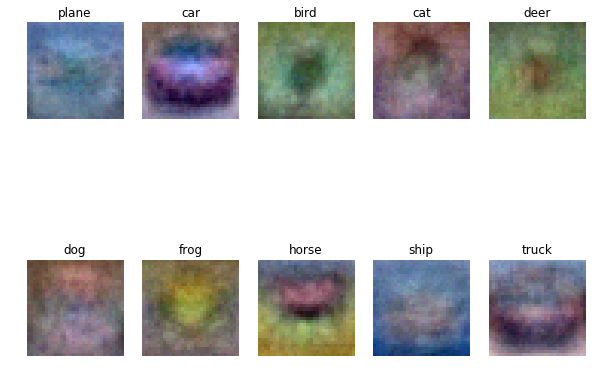

In [29]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])